#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

<b>Цель:</b> Построить модель для предсказания количества заказов. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель CatBoost</a></span></li><li><span><a href="#Модель-Linear-Regression" data-toc-modified-id="Модель-Linear-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель Linear Regression</a></span></li><li><span><a href="#Модель-Random-Forest" data-toc-modified-id="Модель-Random-Forest-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель Random Forest</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]) #чтение файла с данными и запись в переменную

In [3]:
df.head() #вывод первых 5-ти строк

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info() #получаем общую информацию о данных

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.index.is_monotonic #проверка, в хронологическом ли порядке расположены даты и время

True

In [6]:
df = df.resample('1H').sum() #выполняем ресемплирование по одному часу

<b>Вывод: </b>данные подготовлены - индексирование производится по датам, проведена проверка на монотонность, сделано ресемплирование по одному часу.

## Анализ

Определим временной интервал:

In [7]:
print('Дата начала интервала:', df.index.min())
print('Дата окончания интервала:', df.index.max())

Дата начала интервала: 2018-03-01 00:00:00
Дата окончания интервала: 2018-08-31 23:00:00


Таким образом, в нашем распоряжении интервал с 1 марта до 31 августа 2018 года. Отобразим данные на графике:

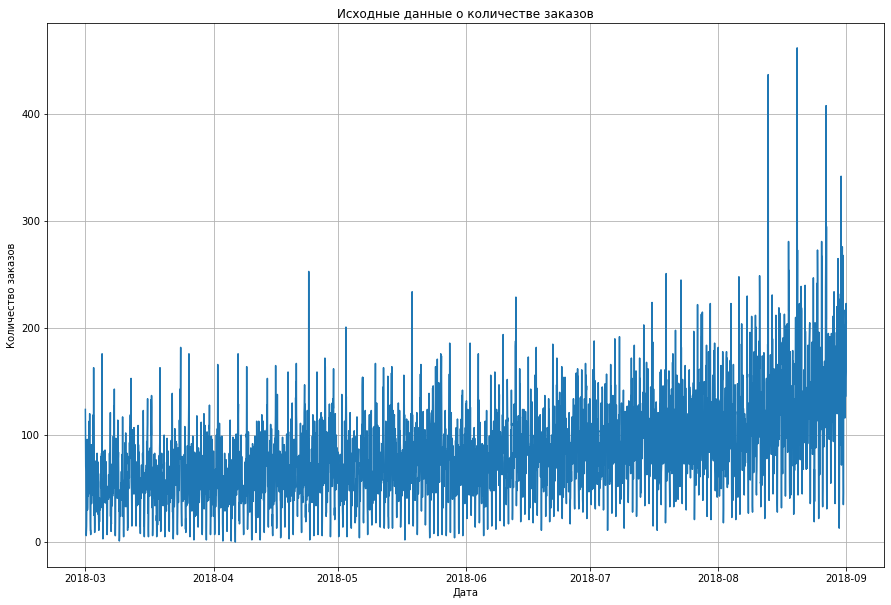

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(df)
plt.title('Исходные данные о количестве заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid()
plt.show()

Видим нестационарный временной ряд. Проведем декомпозицию исходных данных на тренд, сезонную составляющую и остаток:

In [9]:
decomposed = seasonal_decompose(df)

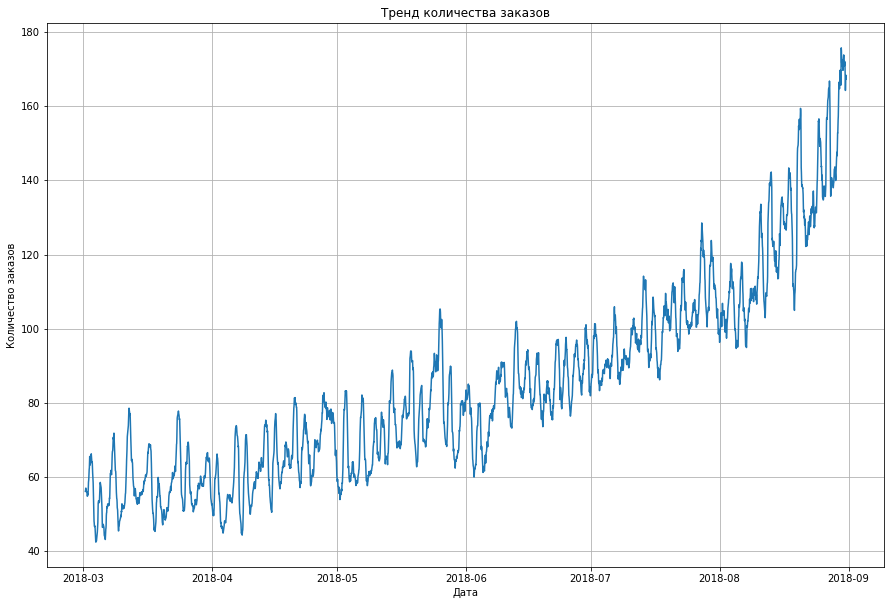

In [10]:
plt.figure(figsize=(15, 10))
plt.plot(decomposed.trend)
plt.title('Тренд количества заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid()
plt.show()

Видим, что количество заказов постепенно увеличивается с началом сезона отпусков. Построим график сезонной составляющей:

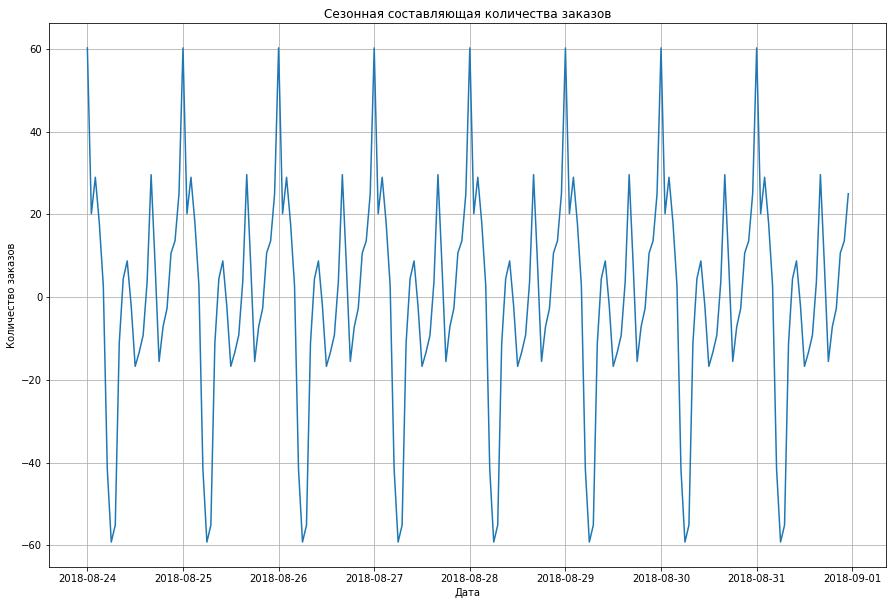

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(decomposed.seasonal['2018-08-24':'2018-08-31'])
plt.title('Сезонная составляющая количества заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid()
plt.show()

Дневной пик вызовов в аэропорт обычно приходится на полночь, а уже ранним утром количество вызовов минимально. Построим диаграмму шумов:

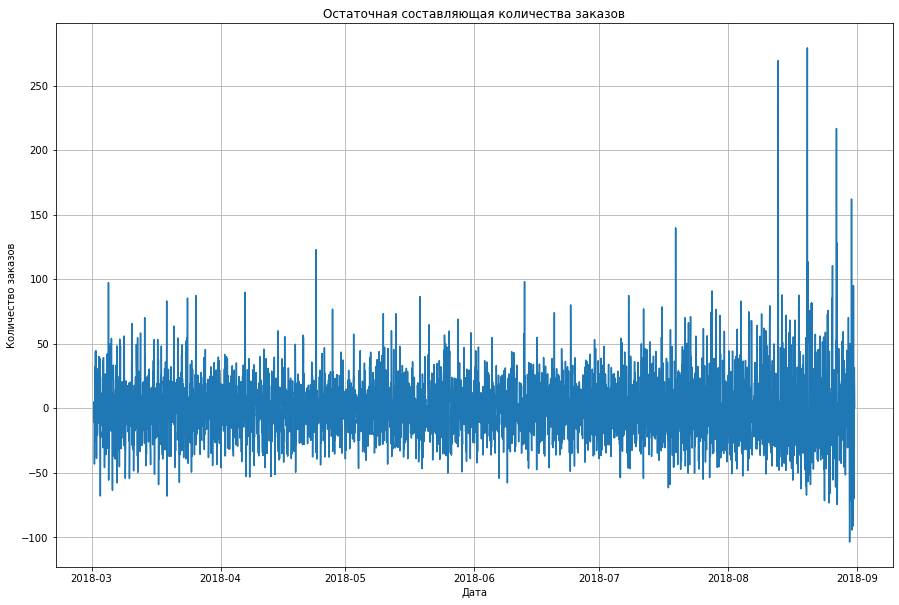

In [12]:
plt.figure(figsize=(15, 10))
plt.plot(decomposed.resid)
plt.title('Остаточная составляющая количества заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid()
plt.show()

В конце августа большие выбросы: люди массово возвращаются из отпусков, возвращаются с каникул студенты и т. д. Видим, что максимальные выбросы вверх были ночью три последних понедельника августа.

In [13]:
decomposed.resid.sort_values(ascending=False)[0:5]

datetime
2018-08-20 02:00:00    279.371423
2018-08-13 02:00:00    269.517257
2018-08-27 02:00:00    216.892257
2018-08-30 17:00:00    162.246651
2018-07-19 10:00:00    139.949065
Name: resid, dtype: float64

А максимальные выбросы вниз в последние два дня августа:

In [14]:
decomposed.resid.sort_values()[0:5]

datetime
2018-08-30 06:00:00   -103.546496
2018-08-30 19:00:00    -94.229897
2018-08-31 03:00:00    -90.927074
2018-08-30 07:00:00    -80.791373
2018-08-27 06:00:00    -74.483996
Name: resid, dtype: float64

<b>Вывод: </b>Данные проанализированы, найден исследуемый период, рассмотрены составляющие данных: тренд, сезонная составляющая и остаток.

## Обучение

In [15]:
#загтовка для итоговой таблицы
ml_models_summary = pd.DataFrame(columns=['Model', 'RMSE', 'Comments'])

model_name_list = []
RMSE_list = []
comment_list = []

### Создание признаков

Функция для создания признаков включает в себя:

1. Календарные признаки
    * Признак месяца
    * Признак дня месяца
    * Признак дня недели
    * Признак часа
2. "Отстающие значения" - предыдущие значения временного ряда, количество задается в функции
3. Скользящее среднее

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

Создаем с помощью функции новые признаки в исходном датасете:

In [17]:
featured_data = make_features(df, 6, 6)

In [18]:
featured_data.head(10) #вывод на экран первых 10ти строк датасета с созданными признаками

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,65.833333
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,47.166667
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,35.500000


Выделим категориальные признаки в отдельный список:

In [19]:
categorical_features_list = ['month', 'day', 'dayofweek', 'hour']

### Модель CatBoost

Разделяем датасет на тренировочную и тестовую выборки с соотношением 0.1:

In [20]:
train, test = train_test_split(featured_data, shuffle=False, test_size=0.1)
train = train.dropna()

Выделяем признаки и таргет в полученных выборках:

In [21]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [22]:
print("Размер тренировочной выборки с признаками: ", features_train.shape)
print("Размер тренировочной выборки с целевым признаком: ", target_train.shape)
print("Размер тестовой выборки с признаками: ", features_test.shape)
print("Размер тестовой выборки с целевым признаком: ", target_test.shape)

Размер тренировочной выборки с признаками:  (3968, 11)
Размер тренировочной выборки с целевым признаком:  (3968,)
Размер тестовой выборки с признаками:  (442, 11)
Размер тестовой выборки с целевым признаком:  (442,)


Для модели CatBoost категориальные признаки не кодировались, т. к. у нее есть встроенный кодировщик.

Подбор параметров для модели и обучение:

In [23]:
train_data = Pool(data=features_train, label=target_train, cat_features=categorical_features_list)

cat = CatBoostRegressor(logging_level='Silent')

grid = {'learning_rate': [0.03, 0.1, 0.15],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(grid, train_data, verbose=False, cv=TimeSeriesSplit(n_splits=5))

In [24]:
model_name_list.append('CatBoost')
comment_list.append(grid_search_result['params'])

### Модель Linear Regression

Закодируем категориальные признаки методом OHE:

In [25]:
data_ohe = featured_data.copy()
data_ohe[categorical_features_list] = data_ohe[categorical_features_list].astype('object')
data_ohe = pd.get_dummies(data_ohe, drop_first=True)

Разделяем данные, определяем признаки и таргет:

In [26]:
train_ohe, test_ohe = train_test_split(data_ohe, shuffle=False, test_size=0.1)
train_ohe = train_ohe.dropna()

In [27]:
features_train_ohe = train_ohe.drop('num_orders', axis=1)
target_train_ohe = train_ohe['num_orders']

features_test_ohe = test_ohe.drop('num_orders', axis=1)
target_test_ohe = test_ohe['num_orders']

In [28]:
print("Размер тренировочной выборки с признаками: ", features_train_ohe.shape)
print("Размер тренировочной выборки с целевым признаком: ", target_train_ohe.shape)
print("Размер тестовой выборки с признаками: ", features_test_ohe.shape)
print("Размер тестовой выборки с целевым признаком: ", target_test_ohe.shape)

Размер тренировочной выборки с признаками:  (3968, 71)
Размер тренировочной выборки с целевым признаком:  (3968,)
Размер тестовой выборки с признаками:  (442, 71)
Размер тестовой выборки с целевым признаком:  (442,)


Обучаем модель:

In [29]:
lr = LinearRegression()

lr.fit(features_train_ohe, target_train_ohe)

model_name_list.append('Linear Regression')
comment_list.append('N/A')

### Модель Random Forest

Выборки для обучения используются те же, что и для линейной регрессии. Ниже подбор параметров для модели. Закомментировал ячейку, чтобы не тратить время, а параметры заданы в хардкоде:

In [30]:
%%time

#словарь варьируемых гиперпараметров для функции GridSearchCV
param_dict = {'max_depth': range(10, 20), 'n_estimators': range(80, 95, 11)}

model = RandomForestRegressor(random_state=12345)
grid = GridSearchCV(model, param_dict, n_jobs=-1, cv=TimeSeriesSplit(n_splits=5))
grid.fit(features_train_ohe, target_train_ohe)
print('Подобранные параметры: ', grid.best_params_)

Подобранные параметры:  {'max_depth': 17, 'n_estimators': 91}
Wall time: 21.3 s


Подобранные параметры:

In [31]:
RF_DEPTH = grid.best_params_['max_depth']
RF_ESTIMATORS = grid.best_params_['n_estimators']

In [32]:
%%time

rfr = RandomForestRegressor(max_depth=RF_DEPTH, n_estimators=RF_ESTIMATORS, random_state=12345)
rfr.fit(features_train_ohe, target_train_ohe)

model_name_list.append('Random Forest')
comment_list.append(f'max_depth={RF_DEPTH}, n_estimators={RF_ESTIMATORS}')

Wall time: 2.09 s


## Тестирование

Рассчитаем RMSE для каждой модели на тестовой выборке:

In [33]:
#функция, принимающая модель и выборки, возвращающая RMSE
def model_predict(model, features_test, target_test, RMSE_list):
    predictions = model.predict(features_test)
    RMSE = mean_squared_error(target_test, predictions, squared=False)
    RMSE_list.append(RMSE)

    return RMSE, predictions

In [34]:
rmse_cat, predictions_cat = model_predict(cat, features_test, target_test, RMSE_list)

print(f'RMSE модели CatBoost: {rmse_cat:.2f}')

RMSE модели CatBoost: 41.58


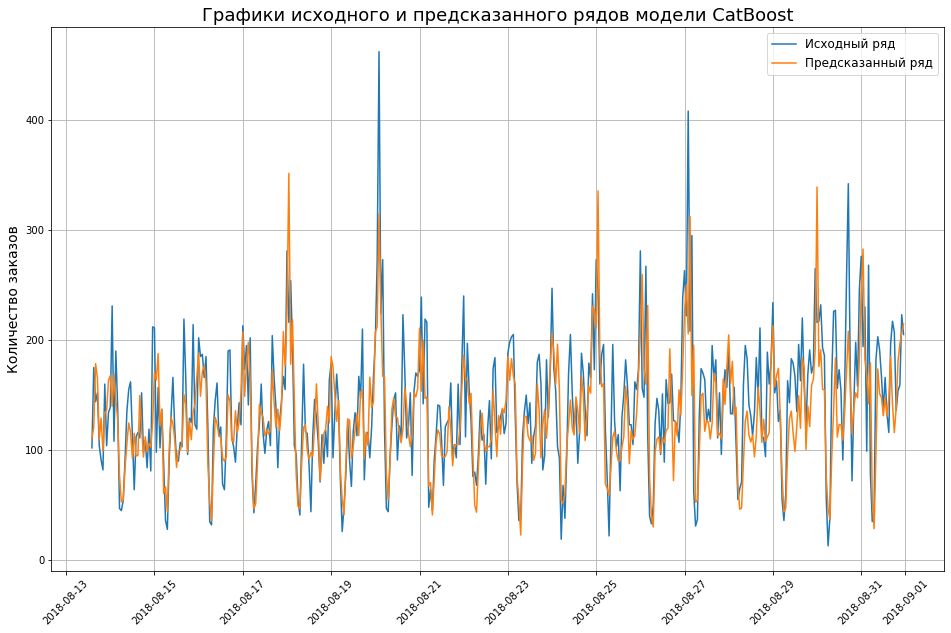

In [35]:
plt.figure(figsize=(16, 10))
plt.plot(target_test)
plt.plot(pd.DataFrame(predictions_cat, target_test.index))
plt.title('Графики исходного и предсказанного рядов модели CatBoost', fontsize=18)
plt.ylabel('Количество заказов', fontsize=14)
plt.legend(['Исходный ряд', 'Предсказанный ряд'], fontsize=12)
plt.xticks(rotation=45)
plt.legend
plt.grid()
plt.show()

In [36]:
rmse_lr, predictions_lr = model_predict(lr, features_test_ohe, target_test_ohe, RMSE_list)

print(f'RMSE модели LinearRegression: {rmse_lr:.2f}')

RMSE модели LinearRegression: 48.30


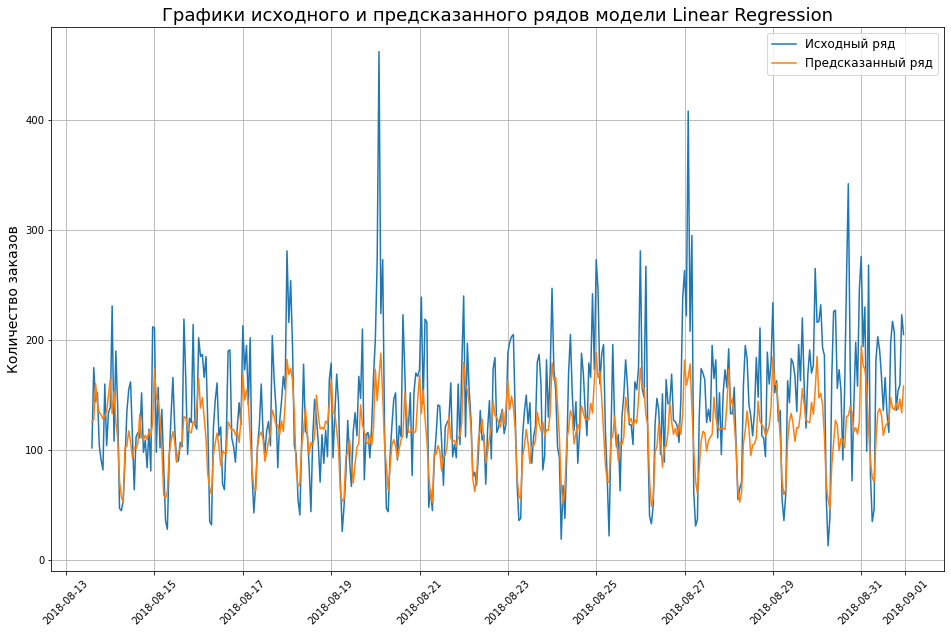

In [37]:
plt.figure(figsize=(16, 10))
plt.plot(target_test)
plt.plot(pd.DataFrame(predictions_lr, target_test.index))
plt.title('Графики исходного и предсказанного рядов модели Linear Regression', fontsize=18)
plt.ylabel('Количество заказов', fontsize=14)
plt.legend(['Исходный ряд', 'Предсказанный ряд'], fontsize=12)
plt.xticks(rotation=45)
plt.legend
plt.grid()
plt.show()

In [38]:
rmse_rf, predictions_rf = model_predict(rfr, features_test_ohe, target_test_ohe, RMSE_list)

print(f'RMSE модели RandomForestRegressor: {rmse_rf:.2f}')

RMSE модели RandomForestRegressor: 48.53


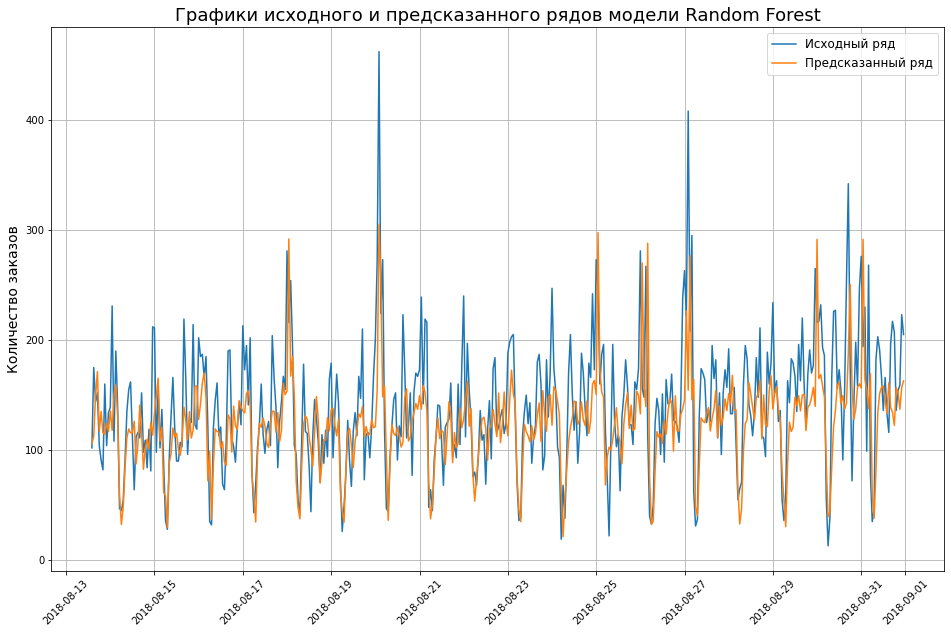

In [39]:
plt.figure(figsize=(16, 10))
plt.plot(target_test)
plt.plot(pd.DataFrame(predictions_rf, target_test.index))
plt.title('Графики исходного и предсказанного рядов модели Random Forest', fontsize=18)
plt.ylabel('Количество заказов', fontsize=14)
plt.legend(['Исходный ряд', 'Предсказанный ряд'], fontsize=12)
plt.xticks(rotation=45)
plt.legend
plt.grid()
plt.show()

<b>Вывод: </b>Лучший результат у CatBoost.

## Общий вывод

В процессе работы были исследованы три модели машинного обучения:

* CatBoost Regression
* Linear Regression
* Random Forest Regresison

Результаты собраны в таблице ниже:

In [40]:
pd.set_option('max_colwidth', 400)

ml_models_summary['Model'] = model_name_list
ml_models_summary['RMSE'] = RMSE_list
ml_models_summary['Comments'] = comment_list

ml_models_summary

,Model,RMSE,Comments
0,CatBoost,41.577542,"{'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.15}"
1,Linear Regression,48.301426,N/A
2,Random Forest,48.526328,"max_depth=17, n_estimators=91"


Самой качественной моделью по метрике RMSE стала CatBoost. Второй результат линейной регрессии. У случайного леса последнее место. CatBoost и линейная регрессия показали результат лучше требуемого RMSE = 48.